Text Summarization using T5 SMALL

# Package Install & Import

In [ ]:
!pip install text_hammer
!pip install spacy
!python -m spacy download en_core_web_md
!pip install sentencepiece
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.11.2
    Uninstalling beautifulsoup4-4.11.2:
      Successfully uninstalled beautifulsoup4-4.11.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yfinance 0.2.31 requires beautifulsoup4>=4.11.1, but you have beautifulsoup4 4.9.1 which is incompatible.
2023-10-31 14:22:23.544030: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-31 14:22:23.544087: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-31 14:22:23.544121:

In [ ]:
# Native Packages
import os
import re
import string
import subprocess
import warnings
warnings.filterwarnings('ignore')

# 3rd party Packages
from google.colab import drive # Mount G-Drive
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
from rouge_score import rouge_scorer
from scipy import stats
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import spacy
import text_hammer as th
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import T5ForConditionalGeneration, T5Tokenizer, AdamW
from tqdm import tqdm
from wordcloud import WordCloud, ImageColorGenerator

In [ ]:
# Checkign for GPU
try:
    subprocess.check_output('nvidia-smi')
    print('Nvidia GPU detected!')
except Exception:
    print('No Nvidia GPU in system!')

Nvidia GPU detected!


# Data Loading

In [ ]:
# Mounting Drive on Colab
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Get the current working directory
cwd = os.getcwd()

# Constructs the file path for the file in the current directory | G-DRIVE Path comment one or the other out
# file_name = "/content/drive/MyDrive/College/Masters/Fall 2023 9-23/Text Analytics/Mini Project/2/news_summary_more.csv"
# Local non G-Drive Path
file_name = "news_summary_more.csv"
file_path = os.path.join(cwd, file_name)

# Checks if the file exists before reading it
if os.path.isfile(file_path):
    # Read the file into a DF
    df = pd.read_csv(file_path)
else:
    print(f"The file {file_name} does not exist in the current directory.")

df

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
...,...,...
98396,CRPF jawan axed to death by Maoists in Chhatti...,A CRPF jawan was on Tuesday axed to death with...
98397,First song from Sonakshi Sinha's 'Noor' titled...,"'Uff Yeh', the first song from the Sonakshi Si..."
98398,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 199..."
98399,Snoop Dogg aims gun at clown dressed as Trump ...,A new music video shows rapper Snoop Dogg aimi...


In [ ]:
#  Checking Nulls, NaNs and Data Description
print("-------------------------")
print("-------------------------")
print("Total NaN Values: " ,df.isna().sum().sum())
print("-------------------------")
print("-------------------------")
print("Total Null Values: ")
print(df.isnull().sum())
print("-------------------------")
print("-------------------------")
print("Describing the Data: ")
print(df.describe())
print("-------------------------")
print("-------------------------")


-------------------------
-------------------------
Total NaN Values:  0
-------------------------
-------------------------
Total Null Values: 
headlines    0
text         0
dtype: int64
-------------------------
-------------------------
Describing the Data: 
                                                headlines  \
count                                               98401   
unique                                              98280   
top     Warne produced 'ball of century' with his 1st ...   
freq                                                    3   

                                                     text  
count                                               98401  
unique                                              98360  
top     Virender Sehwag was captaining India when he h...  
freq                                                    2  
-------------------------
-------------------------


In [ ]:
#identify duplicate rows
print(df[df.duplicated()])

                                               headlines  \
51012  Longest Test innings was longer than 10 footba...   
53731  Captain once dropped himself, replacement brok...   
55374  India marks National Mathematics Day in memory...   
58769  Indian bowler once took 2 hat-tricks in a sing...   
59705  Why is England-Australia Test series called 'T...   
60724  Sachin's debut was not telecast in India due t...   
60885  Who is the cricketer with longest known surnam...   
62063  An ODI was once played in the middle of a Test...   
62575  Virat Kohli took a wicket on the 0th ball of h...   
63533  Bhabha convinced PM Nehru to start India's nuc...   
64468  WeWork offers collaborative co-working space f...   
69673  3 pairs of brothers once played for the same t...   
70249  Inzamam once attacked fan with bat for calling...   
70392  Warne rightly predicted India-Eng 2011 WC matc...   
74095  A solar eclipse once proved Einstein right, Ne...   
75349  Bradman averaged 101.39 before la

# Data Preprocessing

In [ ]:
df = df.drop_duplicates(subset=['headlines', 'text'])

In [ ]:
#identify duplicate rows
print(df[df.duplicated()])


Empty DataFrame
Columns: [headlines, text]
Index: []


In [ ]:
df

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
...,...,...
98396,CRPF jawan axed to death by Maoists in Chhatti...,A CRPF jawan was on Tuesday axed to death with...
98397,First song from Sonakshi Sinha's 'Noor' titled...,"'Uff Yeh', the first song from the Sonakshi Si..."
98398,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 199..."
98399,Snoop Dogg aims gun at clown dressed as Trump ...,A new music video shows rapper Snoop Dogg aimi...


In [ ]:
# lowercasing all the words
df['headlines'] = df.headlines.apply(lambda x: x.lower())
df['text'] = df.text.apply(lambda x: x.lower())

In [ ]:
# DF Cleaning using TEXT_HAMMER library and REG EX
def cleaning(df, column):
    column = column
    print(column)
    df[column] = df[column].progress_apply(lambda x: re.sub('"',"'", x))
    df[column] = df[column].progress_apply(lambda x:th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: re.sub('[^a-zA-Z]+',' ', x))
    df[column] = df[column].progress_apply(lambda x:' '.join([x for x in x.split() if len(x)>=2]) )
    return df[column]

In [ ]:
processed_headlines= cleaning(df, 'headlines')
processed_text= cleaning(df, 'text')

headlines


  0%|          | 0/98379 [00:00<?, ?it/s]

  0%|          | 0/98379 [00:00<?, ?it/s]

  0%|          | 0/98379 [00:00<?, ?it/s]

  0%|          | 0/98379 [00:00<?, ?it/s]

text


  0%|          | 0/98379 [00:00<?, ?it/s]

  0%|          | 0/98379 [00:00<?, ?it/s]

  0%|          | 0/98379 [00:00<?, ?it/s]

  0%|          | 0/98379 [00:00<?, ?it/s]

In [ ]:
# Creates an new DF after Cleaning
processed_df = pd.DataFrame({'headlines':processed_headlines, 'text':processed_text})

In [ ]:
# Downloads the stopwords list, Wordnet and Setting Lemmatizer and Stopword
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

# lemmatize and stopword remover function
def lemmatizeStop(text):
    words = [lemmatizer.lemmatize(word) for word in w_tokenizer.tokenize(text) if word not in stop_words]
    return ' '.join(words)

# Apply lemmatizeStop Func to the columns
processed_df['processedHeadlines'] = processed_df['headlines'].apply(lemmatizeStop)
processed_df['processedText'] = processed_df['text'].apply(lemmatizeStop)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
processed_df

,headlines,text,processedHeadlines,processedText
0,upgrad learner switches to career in ml al wit...,saurav kant an alumnus of upgrad and iiitbs pg...,upgrad learner switch career ml al salary hike,saurav kant alumnus upgrad iiitbs pg program m...
1,delhi techie wins free food from swiggy for on...,kunal shahs credit card bill payment platform ...,delhi techie win free food swiggy one year cred,kunal shah credit card bill payment platform c...
2,new zealand end rohit sharmaled indias match w...,new zealand defeated india by wickets in the f...,new zealand end rohit sharmaled india match wi...,new zealand defeated india wicket fourth odi h...
3,aegon life iterm insurance plan helps customer...,with aegon life iterm insurance plan customers...,aegon life iterm insurance plan help customer ...,aegon life iterm insurance plan customer enjoy...
4,have known hirani for yrs what if metoo claims...,speaking about the sexual harassment allegatio...,known hirani yr metoo claim true sonam,speaking sexual harassment allegation rajkumar...
...,...,...,...,...
98396,crpf jawan axed to death by maoists in chhatti...,crpf jawan was on tuesday axed to death with s...,crpf jawan axed death maoist chhattisgarh,crpf jawan tuesday axed death sharpedged weapo...
98397,first song from sonakshi sinhas noor titled uf...,uff yeh the first song from the sonakshi sinha...,first song sonakshi sinhas noor titled uff yeh,uff yeh first song sonakshi sinha starrer upco...
98398,the matrix film to get reboot reports,according to reports new version of the scienc...,matrix film get reboot report,according report new version science fiction f...
98399,snoop dogg aims gun at clown dressed as trump ...,new music video shows rapper snoop dogg aiming...,snoop dogg aim gun clown dressed trump new video,new music video show rapper snoop dogg aiming ...


# Data Visualization

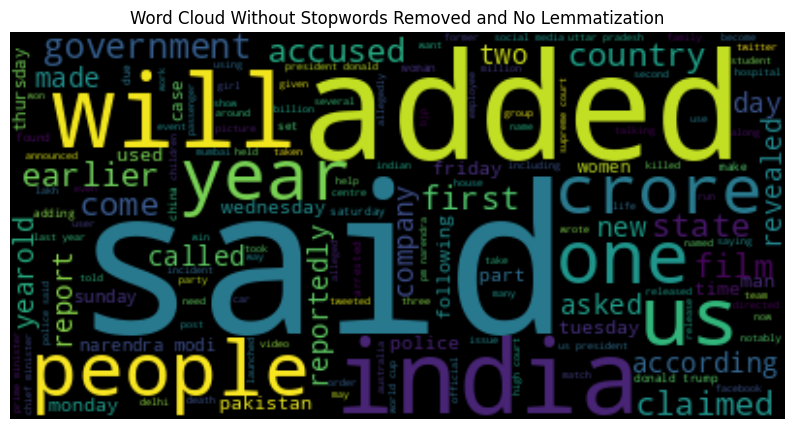

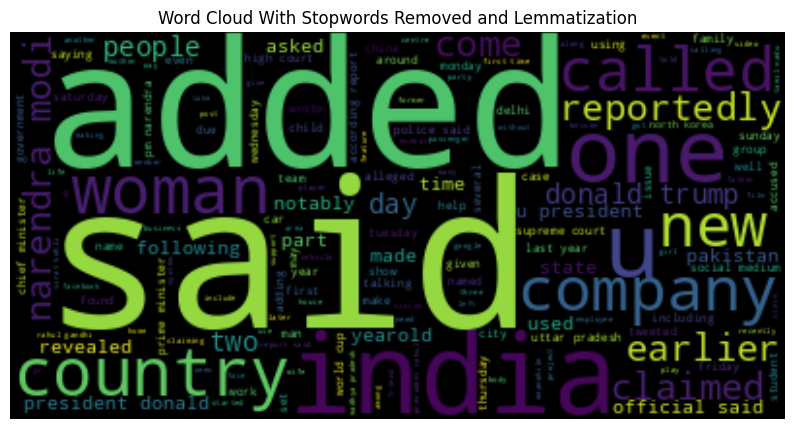

In [ ]:
# Word Cloud Without Lemmatization and No Stopwords present
text = " ".join(i for i in processed_df.text)
wc = WordCloud().generate(text)
plt.figure( figsize=(10,8))
plt.imshow(wc, interpolation='bilinear')
plt.title('Word Cloud Without Stopwords Removed and No Lemmatization')
plt.axis("off")
plt.show()

# Word Cloud With Lemmatization and Stopwords removed
text1 = " ".join(i for i in processed_df.processedText)
wordcloud = WordCloud().generate(text1)
plt.figure( figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud With Stopwords Removed and Lemmatization')
plt.axis("off")
plt.show()

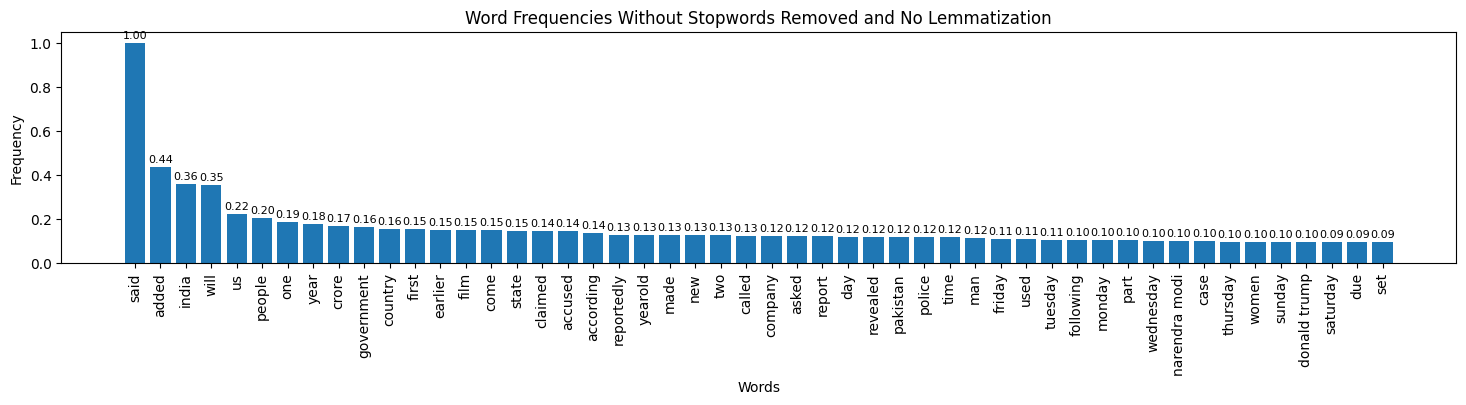

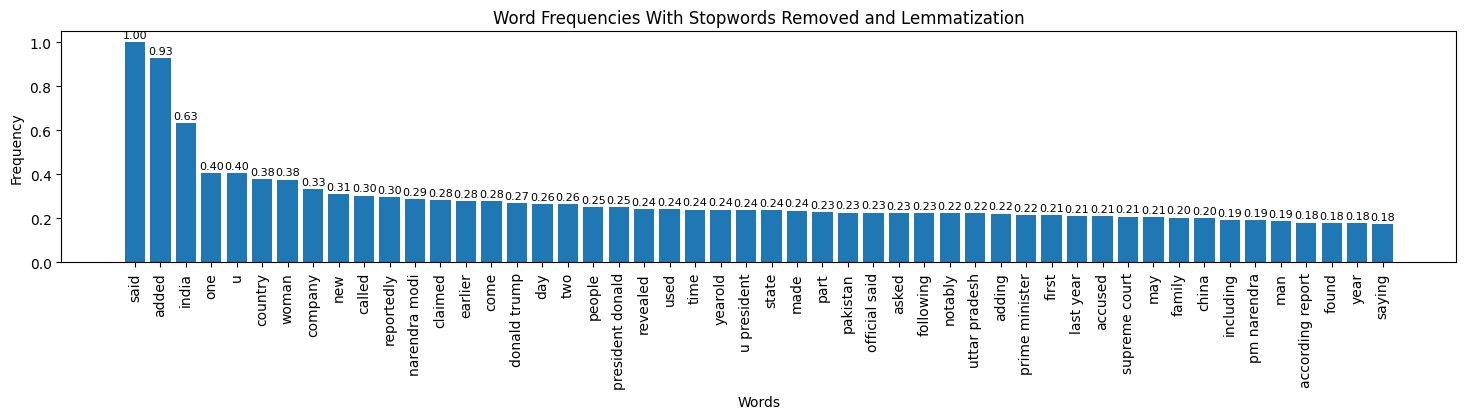

In [ ]:
# The above WC doesn't tell us much so lets plot the word frequencies in a bar graph

# Extracts the word frequencies from the word cloud
word_frequencies_no_lemm_no_stop = wc.words_

# Converts the word frequencies to a DF
word_freq_df_nolemm_nostop = pd.DataFrame(word_frequencies_no_lemm_no_stop.items(), columns=['Word', 'Frequency'])

# Sorts the DF by frequency in descending order
word_freq_df_nolemm_nostop = word_freq_df_nolemm_nostop.sort_values(by='Frequency', ascending=False)

# Limits the DataFrame
word_freq_df_nolemm_nostop = word_freq_df_nolemm_nostop.head(50)

# Creates a bar graph
plt.figure(figsize=(18, 3))
bars = plt.bar(word_freq_df_nolemm_nostop['Word'], word_freq_df_nolemm_nostop['Frequency'])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequencies Without Stopwords Removed and No Lemmatization')
plt.xticks(rotation=90)  # Rotates x-axis labels
# Adds frequency as text labels above the bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords='offset points', ha='center', fontsize=8)

plt.show()

################################################################################
# BAR Graph with Stopwords Removed and Lemmatization

word_frequencies = wordcloud.words_

word_freq_df = pd.DataFrame(word_frequencies.items(), columns=['Word', 'Frequency'])

word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

word_freq_df = word_freq_df.head(50)

plt.figure(figsize=(18, 3))
bars = plt.bar(word_freq_df['Word'], word_freq_df['Frequency'])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequencies With Stopwords Removed and Lemmatization')
plt.xticks(rotation=90)
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords='offset points', ha='center', fontsize=8)
plt.show()

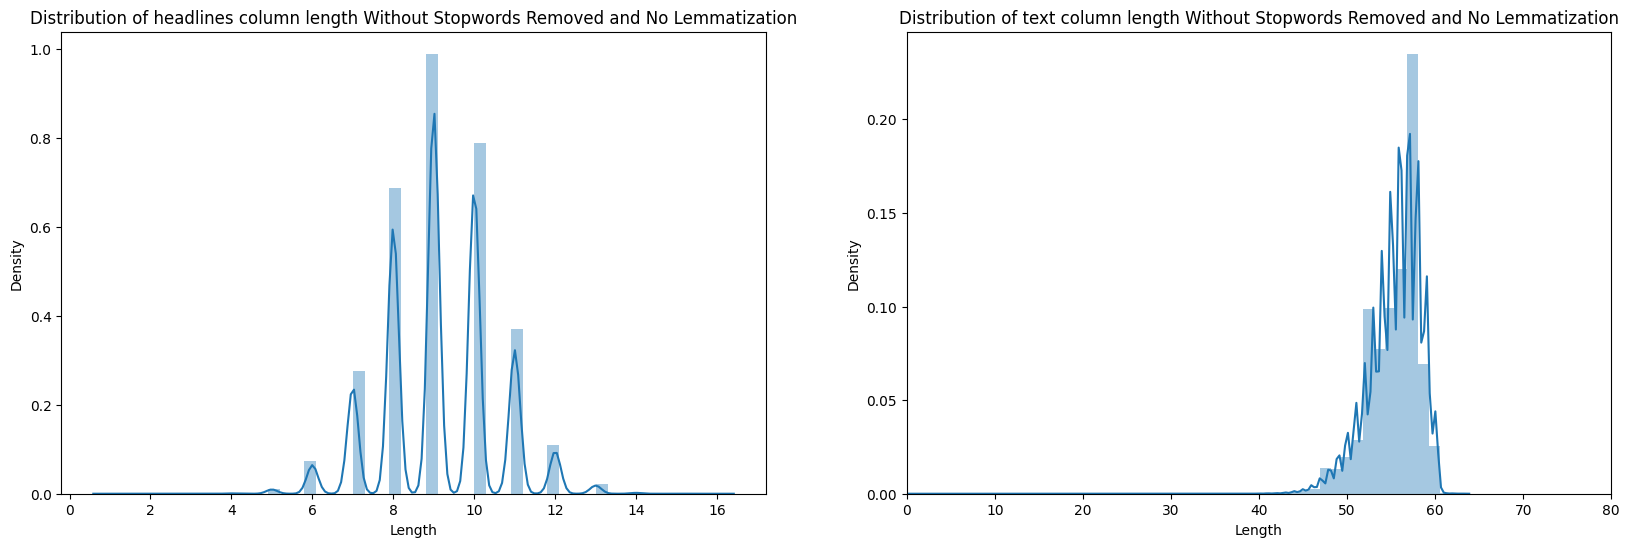

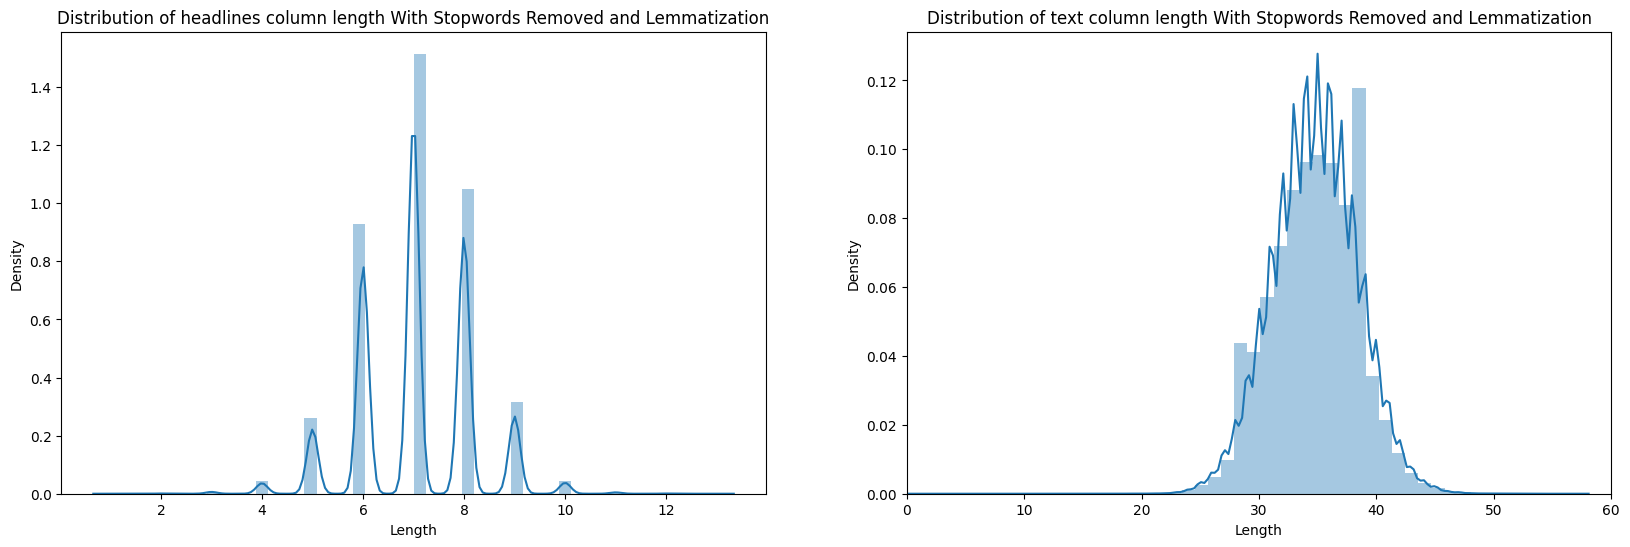

In [ ]:
# Distribution Subplot without Lemmatization and Stowords Present
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
sns.distplot(processed_df['headlines'].str.split().apply(len))
plt.title('Distribution of headlines column length Without Stopwords Removed and No Lemmatization')
plt.xlabel('Length')

plt.subplot(1, 2, 2)
sns.distplot(processed_df['text'].str.split().apply(len))
plt.xlim(0,80)
plt.title('Distribution of text column length Without Stopwords Removed and No Lemmatization')
plt.xlabel('Length')
plt.show()

# Distribution Subplot with Lemmatization and Stowords Removed
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
sns.distplot(processed_df['processedHeadlines'].str.split().apply(len))
plt.title('Distribution of headlines column length With Stopwords Removed and Lemmatization')
plt.xlabel('Length')

plt.subplot(1, 2, 2)
sns.distplot(processed_df['processedText'].str.split().apply(len))
plt.xlim(0,60)
plt.title('Distribution of text column length With Stopwords Removed and Lemmatization')
plt.xlabel('Length')
plt.show()

# Word Embedding | Anamolay Detection

In [ ]:
# Loading a pretrained spacy model with word embeddings
nlp = spacy.load('en_core_web_md')

# Function to get embeddings for a text
def embeddings(text):
    doc = nlp(text)
    return doc.vector  # This gives the vector representation of the entire text

In [ ]:
# Deep Copy of DF
word_embed_df = processed_df.copy(deep=True)
# Applies the function to the DataFrame
word_embed_df['processedText_Embeddings'] = word_embed_df['processedText'].apply(embeddings)
word_embed_df

,headlines,text,processedHeadlines,processedText,processedText_Embeddings
0,upgrad learner switches to career in ml al wit...,saurav kant an alumnus of upgrad and iiitbs pg...,upgrad learner switch career ml al salary hike,saurav kant alumnus upgrad iiitbs pg program m...,"[-0.14603777, 0.41503066, -0.6156369, 0.201348..."
1,delhi techie wins free food from swiggy for on...,kunal shahs credit card bill payment platform ...,delhi techie win free food swiggy one year cred,kunal shah credit card bill payment platform c...,"[-0.8815968, -0.2900009, -1.4266125, -0.307751..."
2,new zealand end rohit sharmaled indias match w...,new zealand defeated india by wickets in the f...,new zealand end rohit sharmaled india match wi...,new zealand defeated india wicket fourth odi h...,"[-1.7543583, 0.6046995, 1.4742233, 0.58891165,..."
3,aegon life iterm insurance plan helps customer...,with aegon life iterm insurance plan customers...,aegon life iterm insurance plan help customer ...,aegon life iterm insurance plan customer enjoy...,"[-0.5364934, -0.40972868, -2.90701, -0.638149,..."
4,have known hirani for yrs what if metoo claims...,speaking about the sexual harassment allegatio...,known hirani yr metoo claim true sonam,speaking sexual harassment allegation rajkumar...,"[0.14067334, 0.5434295, -1.0236585, -0.5892865..."
...,...,...,...,...,...
98396,crpf jawan axed to death by maoists in chhatti...,crpf jawan was on tuesday axed to death with s...,crpf jawan axed death maoist chhattisgarh,crpf jawan tuesday axed death sharpedged weapo...,"[-1.3190387, -0.097954616, -0.8877756, -0.3517..."
98397,first song from sonakshi sinhas noor titled uf...,uff yeh the first song from the sonakshi sinha...,first song sonakshi sinhas noor titled uff yeh,uff yeh first song sonakshi sinha starrer upco...,"[-1.4127471, 0.4409051, -0.04714341, -2.206333..."
98398,the matrix film to get reboot reports,according to reports new version of the scienc...,matrix film get reboot report,according report new version science fiction f...,"[-1.9858955, -0.80694234, 0.047433067, -2.0673..."
98399,snoop dogg aims gun at clown dressed as trump ...,new music video shows rapper snoop dogg aiming...,snoop dogg aim gun clown dressed trump new video,new music video show rapper snoop dogg aiming ...,"[-0.2608426, 0.83720964, -1.6699477, -1.173894..."


In [ ]:
# Saving the above dataframe to csv file for time saving it takes about 20 minutes to run the above code.
word_embed_df.to_csv("word_embed_df.csv",index=False)

In [ ]:
# Creates a numpy array from the text_embeddings column
embeddings = np.array(word_embed_df['processedText_Embeddings'].tolist())

# Determines the number of clusters based on data
# I use a common k formula to find K(atleast i think it is common)
N = word_embed_df.processedText_Embeddings.count()
k = np.sqrt(N)/2
k = round(k)
print(k)

# Fit a K-means model to the embeddings
kmeans = KMeans(n_clusters=k, random_state=42).fit(embeddings)


In [ ]:
# Gets the cluster labels for each data point
cluster_labels = kmeans.labels_

# Calculates the distance of each point to its cluster center
distances = np.linalg.norm(embeddings - kmeans.cluster_centers_[cluster_labels], axis=1)

In [ ]:
# Calculating threshold
# Points with distances above this threshold are considered anomalies
# I will use Z-score to calculate threshold

# Describing Distances to get mean and variance
distance_describe = stats.describe(distances)
print(distance_describe)

# Setting Mean and Variance based on above describe
mean = distance_describe.mean
variance = distance_describe.variance

# Calculates the standard deviation
std_dev = np.sqrt(variance)
print("Standard Deviation: ",std_dev)
# Choosing a Z-score threshold, i will pick 2, higher the threshold lower the anomalies
z_score_threshold = 2

# Calculates the threshold value
threshold = mean + z_score_threshold * std_dev
print("Threshold:", threshold)

# Identifying anomalies
anomalies = word_embed_df[distances > threshold]



DescribeResult(nobs=98379, minmax=(4.6926274, 56.249844), mean=9.515845, variance=2.5903044785028038, skewness=1.2332622977252994, kurtosis=10.912077202398246)
Standard Deviation:  1.6094422880311068
Threshold: 12.734729874829304


In [ ]:
# Prints anomalies
print("Anomalous data points:")
anomalies

Anomalous data points:


,headlines,text,processedHeadlines,processedText,processedText_Embeddings
3,aegon life iterm insurance plan helps customer...,with aegon life iterm insurance plan customers...,aegon life iterm insurance plan help customer ...,aegon life iterm insurance plan customer enjoy...,"[-0.5364934, -0.40972868, -2.90701, -0.638149,..."
17,those on bail will go to jail pm modi takes ji...,in jibe at congress president rahul gandhi pm ...,bail go jail pm modi take jibe rahul,jibe congress president rahul gandhi pm narend...,"[0.040143672, -0.04731676, -0.71808726, -0.534..."
52,headlines,text,headline,text,"[1.8153, -3.0974, 7.8781, 1.7159, 1.3492, -4.6..."
53,oneplus named bestselling premium smartphone b...,oneplus has emerged as indias bestselling prem...,oneplus named bestselling premium smartphone b...,oneplus emerged india bestselling premium smar...,"[-1.7652584, -1.2997806, -1.9794768, 0.8629526..."
172,no law says mlas need to file assets to lokayu...,the aam aadmi party aap on monday said there i...,law say mlas need file asset lokayukta aap,aam aadmi party aap monday said law mention ml...,"[-1.1185181, 0.6335008, -0.913033, 0.19352375,..."
...,...,...,...,...,...
98358,six years since start of syria war over lakh k...,as many as lakh people have been killed and la...,six year since start syria war lakh killed,many lakh people killed lakh others gone missi...,"[-0.812792, 0.48903596, -2.2944272, 0.54976857..."
98359,trump seeks to scrap law that accounted for of...,us president donald trumps leaked tax returns ...,trump seek scrap law accounted tax,u president donald trump leaked tax return rev...,"[-1.4266877, -1.2332876, -2.1127717, 1.3030224..."
98374,karnataka caps movie ticket prices at in all t...,the karnataka government has capped the price ...,karnataka cap movie ticket price theatre,karnataka government capped price movie ticket...,"[-0.9694511, -0.5886851, -1.1060598, -0.512170..."
98379,fake gmail attachment scam fools users into te...,researchers have uncovered gmail phishing scam...,fake gmail attachment scam fool user telling p...,researcher uncovered gmail phishing scam us fa...,"[1.7975974, -0.6034071, 1.2044873, -0.21157864..."


In [ ]:
# Removing Anomalies from Original Dataframe
processed_df_no_anomalies = processed_df.copy(deep=True)
cond = processed_df_no_anomalies['processedText'].isin(anomalies['processedText'])
processed_df_no_anomalies.drop(processed_df_no_anomalies[cond].index, inplace = True)
processed_df_no_anomalies

,headlines,text,processedHeadlines,processedText
0,upgrad learner switches to career in ml al wit...,saurav kant an alumnus of upgrad and iiitbs pg...,upgrad learner switch career ml al salary hike,saurav kant alumnus upgrad iiitbs pg program m...
1,delhi techie wins free food from swiggy for on...,kunal shahs credit card bill payment platform ...,delhi techie win free food swiggy one year cred,kunal shah credit card bill payment platform c...
2,new zealand end rohit sharmaled indias match w...,new zealand defeated india by wickets in the f...,new zealand end rohit sharmaled india match wi...,new zealand defeated india wicket fourth odi h...
4,have known hirani for yrs what if metoo claims...,speaking about the sexual harassment allegatio...,known hirani yr metoo claim true sonam,speaking sexual harassment allegation rajkumar...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan has deni...,rahat fateh ali khan denies getting notice smu...,pakistani singer rahat fateh ali khan denied r...
...,...,...,...,...
98396,crpf jawan axed to death by maoists in chhatti...,crpf jawan was on tuesday axed to death with s...,crpf jawan axed death maoist chhattisgarh,crpf jawan tuesday axed death sharpedged weapo...
98397,first song from sonakshi sinhas noor titled uf...,uff yeh the first song from the sonakshi sinha...,first song sonakshi sinhas noor titled uff yeh,uff yeh first song sonakshi sinha starrer upco...
98398,the matrix film to get reboot reports,according to reports new version of the scienc...,matrix film get reboot report,according report new version science fiction f...
98399,snoop dogg aims gun at clown dressed as trump ...,new music video shows rapper snoop dogg aiming...,snoop dogg aim gun clown dressed trump new video,new music video show rapper snoop dogg aiming ...


In [ ]:
# Saving the above dataframe to csv file for time saving incase kernel crashes
processed_df_no_anomalies.to_csv("processed_df_no_anomalies.csv",index=False)

# Split Data

In [ ]:
#Splitting Data into Train, Test, and Validate - 60/20/20
train_data, temp_data = train_test_split(processed_df_no_anomalies, test_size=0.4, random_state=42)
test_data, valid_data = train_test_split(temp_data, test_size=0.5, random_state=42)
train_data

,headlines,text,processedHeadlines,processedText
68918,sc denies anticipatory bail to bwood producer ...,the supreme court has denied anticipatory bail...,sc denies anticipatory bail bwood producer rap...,supreme court denied anticipatory bail bollywo...
78007,richest americans added bn to their wealth in,the five richest people in the us have added n...,richest american added bn wealth,five richest people u added nearly billion lak...
3242,in many ways am glad my parents were not toget...,speaking about her parents divorce actress sar...,many way glad parent together sara ali khan,speaking parent divorce actress sara ali khan ...
46902,kerala makes vaccination mandatory for school ...,kerala has made it mandatory for parents to sh...,kerala make vaccination mandatory school admis...,kerala made mandatory parent show record child...
88014,not sure if fleming dressed for ipl or cannes ...,reacting to rising pune supergiant coach steph...,sure fleming dressed ipl cannes tweet user,reacting rising pune supergiant coach stephen ...
...,...,...,...,...
6437,man dies after crashing his scooter into zaree...,yearold man named nitesh goral who was riding ...,man dy crashing scooter zareen khan car goa,yearold man named nitesh goral riding scooter ...
56768,telangana cm to distribute sheep to lakh yadav...,telangana cm chandrashekar rao has announced d...,telangana cm distribute sheep lakh yadav family,telangana cm chandrashekar rao announced distr...
79532,new york hosts annual toilet paper wedding dre...,toilet paper wedding dress with handcut butter...,new york host annual toilet paper wedding dres...,toilet paper wedding dress handcut butterfly s...
883,punjabi singer ammy virk to play expacer balwi...,punjabi singeractor ammy virk will be making h...,punjabi singer ammy virk play expacer balwinde...,punjabi singeractor ammy virk making bollywood...


# T5 Small Model Pretrained

In [ ]:
# Loads pre-trained T5 model for summarization
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# Input_text for the T5 Model
input_text = train_data["text"].loc[78007]
print("Text: ",input_text)
print("------------------------------------------------------------------------------------------------")
# Headline for Generated and default comparison | Default Headline
input_headline= train_data["headlines"].loc[78007]
print("Headline: ",input_headline)
print("------------------------------------------------------------------------------------------------")
# Input_text for the T5 Model based on processedText Column
input_processedText = train_data["processedText"].loc[78007]
print("processedText: ",input_processedText)
print("------------------------------------------------------------------------------------------------")
# Headline for Generated and default comparison | Processed Headline
input_processedHeadline= train_data["processedHeadlines"].loc[78007]
print("processedHeadline: ",input_processedHeadline)

Text:  the five richest people in the us have added nearly billion lakh crore combined to their personal fortunes since beginning these were technology firms founders bill gates jeff bezos mark zuckerberg and larry ellison along with billionaire investor warren buffett zuckerberg was the biggest gainer in the group with billion boost to his net worth
------------------------------------------------------------------------------------------------
Headline:  richest americans added bn to their wealth in
------------------------------------------------------------------------------------------------
processedText:  five richest people u added nearly billion lakh crore combined personal fortune since beginning technology firm founder bill gate jeff bezos mark zuckerberg larry ellison along billionaire investor warren buffett zuckerberg biggest gainer group billion boost net worth
------------------------------------------------------------------------------------------------
processedHeadl

In [ ]:
# Max and mean Row Length for Text column
print("text Mean: ",(train_data['text'].apply(len).mean()))
print("text Max: ",(train_data['text'].apply(len).max()))
print("-------------------------------------------------")
# Max and mean Row Length for processedText column
print("processedText Mean: ",(train_data['processedText'].apply(len).mean()))
print("processedText Max: ",(train_data['processedText'].apply(len).max()))
print("-------------------------------------------------")
# Max and mean Row Length for Headlines column
print("headlines Max: ",train_data['headlines'].apply(len).max())
print("headlines Mean: ",train_data['headlines'].apply(len).mean())
print("-------------------------------------------------")
# Max and mean Row Length for processedHeadlines column
print("processedHeadlines Max: ",train_data['processedHeadlines'].apply(len).max())
print("processedHeadlines Mean: ",train_data['processedHeadlines'].apply(len).mean())

text Mean:  338.14575318401404
text Max:  424
-------------------------------------------------
processedText Mean:  251.96922266139657
processedText Max:  366
-------------------------------------------------
headlines Max:  74
headlines Mean:  54.54912604303909
-------------------------------------------------
processedHeadlines Max:  69
processedHeadlines Mean:  45.59741765480896


In [ ]:
# Running on Pretrained T5-Small
# Input text to be summarized
print("Default Text:")
print(input_text)

# Tokenize the input text, MAX_LENGTH base on text Mean
input_ids = tokenizer.encode("summarize: " + input_text, return_tensors="pt", max_length=450, truncation=True)
# print("Input IDs:", input_ids)
# Generate a summary using T5, MAX_LENGTH base on Headline Mean
output = model.generate(input_ids, max_length=55, num_return_sequences=1, no_repeat_ngram_size=2, top_k=50, top_p=0.95, early_stopping=True)
# print("Generated Output:", output)
# Decodes and prints the generated summary
generated_summary = tokenizer.decode(output[0], skip_special_tokens=True)
print("Generated Summary:")
print(generated_summary)
print("Default Summary:")
print(input_headline)


Default Text:
the five richest people in the us have added nearly billion lakh crore combined to their personal fortunes since beginning these were technology firms founders bill gates jeff bezos mark zuckerberg and larry ellison along with billionaire investor warren buffett zuckerberg was the biggest gainer in the group with billion boost to his net worth
Generated Summary:
billions combined to their personal fortunes have been added to the group since beginning. billionaire investor warren buffett zuckerberg was the biggest gainer in the u.s. group boosted by billion boost to net worth he had a
Default Summary:
richest americans added bn to their wealth in


# T5 Fine Tuned on processed columns with LEMM and Stopwords Removed

In [ ]:
# Defines custom dataset
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, max_input_length, max_target_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['processedText']
        summary = self.data.iloc[idx]['processedHeadlines']

        input_text = f"summarize: {text}"
        target_text = summary

        inputs = self.tokenizer(input_text, truncation=True, padding='max_length', max_length=self.max_input_length, return_tensors='pt')
        targets = self.tokenizer(target_text, truncation=True, padding='max_length', max_length=self.max_target_length, return_tensors='pt')

        return {
            'input_ids': inputs.input_ids.squeeze(),
            'attention_mask': inputs.attention_mask.squeeze(),
            'labels': targets.input_ids.squeeze(),
        }


In [ ]:
# Defines custom data loaders
max_input_length = 450
max_target_length = 55
batch_size = 16

train_dataset = CustomDataset(train_data, tokenizer, max_input_length, max_target_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Defines the training parameters
learning_rate = .006
num_epochs = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Training loop
model.train()

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [ ]:
# Training the Model
for epoch in range(num_epochs):
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch}', position=0, leave=True)

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress_bar.set_postfix(loss=total_loss / len(train_loader))


Epoch 2: 100%|██████████| 3558/3558 [28:49<00:00,  2.06it/s, loss=0.898]


In [ ]:
# Save the fine-tuned model
model.save_pretrained("fine_tuned_t5_small_summarizer_with_lemm_stop")

In [ ]:
print(input_processedText)

# Tokenize the input text
input_ids = tokenizer.encode("summarize: " + input_processedText, return_tensors="pt", max_length=400, truncation=True)

# Moves the input_ids tensor to the same device as the model
input_ids = input_ids.to(device)


# Generates a summary using the fine-tuned T5 model
output = model.generate(input_ids, max_length=55, num_return_sequences=1, no_repeat_ngram_size=2, top_k=50, top_p=0.95, early_stopping=True)

# Decodes and prints the generated summary
generated_summary = tokenizer.decode(output[0], skip_special_tokens=True)
print("Default Headline:")
print(input_processedHeadline)
print("Generated Headline:")
print(generated_summary)


five richest people u added nearly billion lakh crore combined personal fortune since beginning technology firm founder bill gate jeff bezos mark zuckerberg larry ellison along billionaire investor warren buffett zuckerberg biggest gainer group billion boost net worth
Default Headline:
richest american added bn wealth
Generated Headline:
richest people u net net worth crore bn


In [ ]:
# Ran it after Kernel Crash thats why manual text

# Default Summary and Generated summaries from above
default_summary = "richest american added bn wealth"
generated_summary = "richest people u net net worth crore bn"

# Initializes the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculates ROUGE scores
scores = scorer.score(default_summary, generated_summary)

# Extracts F1, recall, and precision scores for ROUGE-1, ROUGE-2, and ROUGE-L
rouge1_recall = scores['rouge1'][0]  # Recall for ROUGE-1
rouge1_precision = scores['rouge1'][1]  # Precision for ROUGE-1
rouge1_f1 = scores['rouge1'][2]  # F1-score for ROUGE-1

rouge2_recall = scores['rouge2'][0]  # Recall for ROUGE-2
rouge2_precision = scores['rouge2'][1]  # Precision for ROUGE-2
rouge2_f1 = scores['rouge2'][2]  # F1-score for ROUGE-2

rougeL_recall = scores['rougeL'][0]  # Recall for ROUGE-L
rougeL_precision = scores['rougeL'][1]  # Precision for ROUGE-L
rougeL_f1 = scores['rougeL'][2]  # F1-score for ROUGE-L

# Print the scores
print(f'ROUGE-1 Recall: {rouge1_recall:.2f}')
print(f'ROUGE-1 Precision: {rouge1_precision:.2f}')
print(f'ROUGE-1 F1 Score: {rouge1_f1:.2f}')

print(f'ROUGE-2 Recall: {rouge2_recall:.2f}')
print(f'ROUGE-2 Precision: {rouge2_precision:.2f}')
print(f'ROUGE-2 F1 Score: {rouge2_f1:.2f}')

print(f'ROUGE-L Recall: {rougeL_recall:.2f}')
print(f'ROUGE-L Precision: {rougeL_precision:.2f}')
print(f'ROUGE-L F1 Score: {rougeL_f1:.2f}')



ROUGE-1 Recall: 0.25
ROUGE-1 Precision: 0.40
ROUGE-1 F1 Score: 0.31
ROUGE-2 Recall: 0.00
ROUGE-2 Precision: 0.00
ROUGE-2 F1 Score: 0.00
ROUGE-L Recall: 0.25
ROUGE-L Precision: 0.40
ROUGE-L F1 Score: 0.31


#T5 Fine Tuned of Default No Lemm and No Stopwords Removed DF

In [ ]:
# Defines custom dataset
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, max_input_length, max_target_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        summary = self.data.iloc[idx]['headlines']

        input_text = f"summarize: {text}"
        target_text = summary

        inputs = self.tokenizer(input_text, truncation=True, padding='max_length', max_length=self.max_input_length, return_tensors='pt')
        targets = self.tokenizer(target_text, truncation=True, padding='max_length', max_length=self.max_target_length, return_tensors='pt')

        return {
            'input_ids': inputs.input_ids.squeeze(),
            'attention_mask': inputs.attention_mask.squeeze(),
            'labels': targets.input_ids.squeeze(),
        }


In [ ]:
# Defines custom data loaders
max_input_length = 450
max_target_length = 55
batch_size = 16

# Creates a train dataset and dataloader
train_dataset = CustomDataset(train_data, tokenizer, max_input_length, max_target_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Creates a validation dataset and dataloader
val_dataset = CustomDataset(valid_data, tokenizer, max_input_length, max_target_length)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Defines the training parameters
learning_rate = .006
num_epochs = 3

# Using Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Training loop
model.train()

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [ ]:
# Training and validation loop
for epoch in range(num_epochs):
    total_loss = 0
    total_val_loss = 0

    # Training loop
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch}', position=0, leave=True)
    model.train()  # Sets the model to training mode

    for batch in progress_bar:
        # Training steps
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress_bar.set_postfix(loss=total_loss / len(train_loader))
    # Validation loop
    model.eval()  # Sets the model to evaluation mode
    with torch.no_grad():
        for val_batch in val_loader:
            input_ids_val = val_batch['input_ids'].to(device)
            attention_mask_val = val_batch['attention_mask'].to(device)
            labels_val = val_batch['labels'].to(device)

            outputs_val = model(input_ids=input_ids_val, attention_mask=attention_mask_val, labels=labels_val)
            val_loss = outputs_val.loss
            total_val_loss += val_loss.item()

    # Calculates and prints the average validation loss
    average_val_loss = total_val_loss / len(val_loader)
    print(f'Validation Loss: {average_val_loss}')

    # Training loss
    progress_bar.set_postfix(loss=total_loss / len(train_loader))

Epoch 0: 100%|██████████| 3558/3558 [29:06<00:00,  2.04it/s, loss=0.675]


Validation Loss: 0.5917319882830722


Epoch 1: 100%|██████████| 3558/3558 [29:11<00:00,  2.03it/s, loss=0.694]


Validation Loss: 0.5725308417469815


Epoch 2: 100%|██████████| 3558/3558 [29:06<00:00,  2.04it/s, loss=0.584]


Validation Loss: 0.5352085093774441


In [ ]:
# Save the fine-tuned model
model.save_pretrained("fine_tuned_t5_small_summarizer")

In [ ]:
# Using ProcessedText Column This is with Lemmatization and Stopwords Removed

print(input_processedText)

# Tokenize the input text
input_ids = tokenizer.encode("summarize: " + input_processedText, return_tensors="pt", max_length=400, truncation=True)

# Move the input_ids tensor to the same device as the model
input_ids = input_ids.to(device)


# Generate a summary using the fine-tuned T5 model
output = model.generate(input_ids, max_length=55, num_return_sequences=1, no_repeat_ngram_size=2, top_k=50, top_p=0.95, early_stopping=True)

# Decode and print the generated summary
generated_summary = tokenizer.decode(output[0], skip_special_tokens=True)
print("Default Headline:")
print(input_processedHeadline)
print("Generated Headline:")
print(generated_summary)


five richest people u added nearly billion lakh crore combined personal fortune since beginning technology firm founder bill gate jeff bezos mark zuckerberg larry ellison along billionaire investor warren buffett zuckerberg biggest gainer group billion boost net worth
Default Headline:
richest american added bn wealth
Generated Headline:
richest people add cr in years since beginning tech firm


In [ ]:
# Using Text Column This is with without Lemmatization and Stopwords Present

print(input_text)

# Tokenize the input text
input_ids = tokenizer.encode("summarize: " + input_text, return_tensors="pt", max_length=400, truncation=True)

# Move the input_ids tensor to the same device as the model
input_ids = input_ids.to(device)


# Generate a summary using the fine-tuned T5 model
output = model.generate(input_ids, max_length=55, num_return_sequences=1, no_repeat_ngram_size=2, top_k=50, top_p=0.95, early_stopping=True)

# Decode and print the generated summary
generated_summary = tokenizer.decode(output[0], skip_special_tokens=True)
print("Default Headline:")
print(input_processedHeadline) # This should be input_headline
print("Generated Headline:")
print(generated_summary)


the five richest people in the us have added nearly billion lakh crore combined to their personal fortunes since beginning these were technology firms founders bill gates jeff bezos mark zuckerberg and larry ellison along with billionaire investor warren buffett zuckerberg was the biggest gainer in the group with billion boost to his net worth
Default Headline:
richest american added bn wealth
Generated Headline:
richest people add cr in us


# Rouge Score = Ran it after Kernel Crash so that's why not automatically grabbing Data

In [ ]:
# For T5 Second model LEMMATIZATION AND StopWords Removed

# Default Summary and Generated summaries from above
default_summary = "richest american added bn wealth"
generated_summary = "richest people add cr in years since beginning tech firm"

# Initializes the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculates ROUGE scores
scores = scorer.score(default_summary, generated_summary)

# Extracts F1, recall, and precision scores for ROUGE-1, ROUGE-2, and ROUGE-L
rouge1_recall = scores['rouge1'][0]  # Recall for ROUGE-1
rouge1_precision = scores['rouge1'][1]  # Precision for ROUGE-1
rouge1_f1 = scores['rouge1'][2]  # F1-score for ROUGE-1

rouge2_recall = scores['rouge2'][0]  # Recall for ROUGE-2
rouge2_precision = scores['rouge2'][1]  # Precision for ROUGE-2
rouge2_f1 = scores['rouge2'][2]  # F1-score for ROUGE-2

rougeL_recall = scores['rougeL'][0]  # Recall for ROUGE-L
rougeL_precision = scores['rougeL'][1]  # Precision for ROUGE-L
rougeL_f1 = scores['rougeL'][2]  # F1-score for ROUGE-L

# Print the scores
print(f'ROUGE-1 Recall: {rouge1_recall:.2f}')
print(f'ROUGE-1 Precision: {rouge1_precision:.2f}')
print(f'ROUGE-1 F1 Score: {rouge1_f1:.2f}')

print(f'ROUGE-2 Recall: {rouge2_recall:.2f}')
print(f'ROUGE-2 Precision: {rouge2_precision:.2f}')
print(f'ROUGE-2 F1 Score: {rouge2_f1:.2f}')

print(f'ROUGE-L Recall: {rougeL_recall:.2f}')
print(f'ROUGE-L Precision: {rougeL_precision:.2f}')
print(f'ROUGE-L F1 Score: {rougeL_f1:.2f}')



ROUGE-1 Recall: 0.10
ROUGE-1 Precision: 0.20
ROUGE-1 F1 Score: 0.13
ROUGE-2 Recall: 0.00
ROUGE-2 Precision: 0.00
ROUGE-2 F1 Score: 0.00
ROUGE-L Recall: 0.10
ROUGE-L Precision: 0.20
ROUGE-L F1 Score: 0.13


In [ ]:
# For T5 Second model NO LEMMATIZATION AND StopWords Present

# Default Summary and Generated summaries from above
default_summary = "richest americans added bn to their wealth in"
generated_summary = "richest people add cr in us"

# Initializes the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculates ROUGE scores
scores = scorer.score(default_summary, generated_summary)

# Extracts F1, recall, and precision scores for ROUGE-1, ROUGE-2, and ROUGE-L
rouge1_recall = scores['rouge1'][0]  # Recall for ROUGE-1
rouge1_precision = scores['rouge1'][1]  # Precision for ROUGE-1
rouge1_f1 = scores['rouge1'][2]  # F1-score for ROUGE-1

rouge2_recall = scores['rouge2'][0]  # Recall for ROUGE-2
rouge2_precision = scores['rouge2'][1]  # Precision for ROUGE-2
rouge2_f1 = scores['rouge2'][2]  # F1-score for ROUGE-2

rougeL_recall = scores['rougeL'][0]  # Recall for ROUGE-L
rougeL_precision = scores['rougeL'][1]  # Precision for ROUGE-L
rougeL_f1 = scores['rougeL'][2]  # F1-score for ROUGE-L

# Print the scores
print(f'ROUGE-1 Recall: {rouge1_recall:.2f}')
print(f'ROUGE-1 Precision: {rouge1_precision:.2f}')
print(f'ROUGE-1 F1 Score: {rouge1_f1:.2f}')

print(f'ROUGE-2 Recall: {rouge2_recall:.2f}')
print(f'ROUGE-2 Precision: {rouge2_precision:.2f}')
print(f'ROUGE-2 F1 Score: {rouge2_f1:.2f}')

print(f'ROUGE-L Recall: {rougeL_recall:.2f}')
print(f'ROUGE-L Precision: {rougeL_precision:.2f}')
print(f'ROUGE-L F1 Score: {rougeL_f1:.2f}')



ROUGE-1 Recall: 0.33
ROUGE-1 Precision: 0.25
ROUGE-1 F1 Score: 0.29
ROUGE-2 Recall: 0.00
ROUGE-2 Precision: 0.00
ROUGE-2 F1 Score: 0.00
ROUGE-L Recall: 0.33
ROUGE-L Precision: 0.25
ROUGE-L F1 Score: 0.29


# Conclusion

Summarization to some extent makes sense but it is not consistent for every new generation for lemmatization and SW Removed Model, it gives me a different outcome sometimes good and sometimes not so good.

Model Built using ProcessedText (Lemmatization and StopWords Removed) performed the best after looking at the ROUGE SCORE.

Model Built using No Lemm and SW Present data performed on par with the above model if lemmatized and SW Removed input processedtext was used.

Overall, I was able to achieve my Goal of finding an anomaly and discarding it, and then running a Summarization on the Text using a Finetuned T5 Model.


# Improvements

Playing with Epochs and Batch Size Tuning. Since Validation Loss is decreasing as the epochs increase it is best to have more epochs.

Using other T5 model that is trained on a greater amount of data.

Summary Generation Consistency for Lemmatization and SW Removed Model.

Implementation of Anomaly Detection on a Granular Level e.g., Type of Anomaly, causes of Anomaly (world event). Using that Anomaly to generate a Summary or a Story.
